# Role of Tweaks in Deep Learning
**M. Zadem, K. Abouda, TH. Yen VU**

This notebook illustrates the roles of some techniques in Deep Learning such as **Dropout**, **Large Initial Step Size**, **Batch Normalization**, **Initialization** and **Weight Decay**.

We'll use a simple CNN architecture to perform a simple classification task using the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) which provides 60000 32x32-pixel images, classified into 10 categories.

# Table of content

[0. Preparation for training](#preparation)<br>
- [0.1. Import necessary libraries](#import)<br>
- [0.2. Download and preprocess the CIFAR10 dataset from Keras](#download)<br>
- [0.3. The base CNN model for training](#cnn)<br>
- [0.4. Define function to monitor training](#train_model)<br>

[I. Dropout](#Dropout)<br>
[II. Learning Rate](#lr)<br>
[III. Batch Normalization](#bn)<br>
[IV. Initialization Methods](#init)<br>
[V. Weight Decay](#decay)<br>

# 0 - Preparation for training <a id='preparation'></a>

<a id='import'></a>
## 0.1 - Import necessary libraries

In [0]:
# import os
# import time
# import datetime
# from tqdm import tqdm_notebook

import numpy as np
import matplotlib.pyplot as plt
# import pandas
# from sklearn import metrics

# import torch
# from torch import nn
# import torch.nn.functional as F
# from torchvision import datasets, transforms, utils
# from torch.utils.data import Dataset, DataLoader
# import torch.optim as optim

from keras.layers import Dense, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, BatchNormalization
from keras.optimizers import SGD
from keras.datasets import cifar10
from keras.utils.np_utils import to_categorical
from keras.models import Model
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.initializers import RandomNormal, RandomUniform
from keras import regularizers

Using TensorFlow backend.


<a id='download'></a>
## 0.2 - Download and preprocess the CIFAR10 dataset from Keras

In [0]:
def load_cifar_data():
    """
    Loads the CIFAR-10 dataset using Keras and preprocess for training.
    """
    # Download / Load the datasets
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    
    # Normalize the data
    y_train = to_categorical(y_train, 10)
    y_test  = to_categorical(y_test, 10)
    x_train = x_train.astype('float32') / 255
    x_test  = x_test.astype('float32') / 255
    
    # Label vector
    labels = [
        'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 
        'frog', 'horse', 'ship', 'truck'
    ]
    
    return x_train, y_train, x_test, y_test, labels

x_train, y_train, x_test, y_test, labels = load_cifar_data()

170500096/170498071 [==============================] - 13s 0us/step


**Check the shape of the dataset.**

In [0]:
print("Shape of training images is:", x_train.shape)
print("Shape of training labels is:", y_train.shape)
print("Shape of test images is:", x_test.shape)
print("Shape of test labels is:", y_test.shape)

Shape of training images is: (50000, 32, 32, 3)
Shape of training labels is: (50000, 10)
Shape of test images is: (10000, 32, 32, 3)
Shape of test labels is: (10000, 10)


<a id='cnn'></a>
## 0.3 - The base CNN model for training 

In this work, we'll use a simple CNN architecture with 2 blocks of 2DConv followed by a maxpooling, then another 2 blocks of 2DConv followed by another maxpooling, then the output is flattened and is passed through a Dense layer before a last layer to classify the image. The layers are described as follows :
  - 3x3 2D convolution with zero padding (same), 32 filters
  - ReLU activation
  - 3,3 2D convolution, no padding, 32 filters
  - ReLU activation
  - Max pooling with size (2,2)
  - 3x3 2D convolution, no padding, 64 filters
  - ReLU activation
  - 3x3 2D convolution, no padding, 64 filters
  - ReLU activation
  - Max pooling with size (2,2)
  - Flatten
  - Dense layer with 512 nodes, ReLU activation
  - Softmax output layer with 10 nodes

The network can be created through the following function:
```python
def cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32,(3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
  
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
 
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    sgd = SGD(lr=0.1, decay=1.0e-6)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

# Create the model
model = cnn_model(x_train.shape[1:], 10)
```

## 0.4 - Define function to monitor training <a id='train_model'></a>
The following function define a function to peform training the model.

In [0]:
def train_model(model, x, y, batch_size=32, epochs=10, file_name=None):
    """
    Trains the model on the given data.
    """
    
    stop_early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=2, mode='auto')
    
    ret = model.fit(x, y, batch_size=batch_size, epochs=epochs, validation_split=0.2, shuffle=True, 
                    callbacks=[stop_early], verbose = 1)
    
    if file_name:
        model.save(file_name)
    
    return ret

<a id='Dropout'></a>
# I - Dropout

In [0]:
def cnn_model_dropout(input_shape, num_classes,p):
    #A CNN model that uses dropout with parameter p: probability of keeping a neuron
    
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32,(3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
  
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
 
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(num_classes))

    model.add(Dropout(1-p))

    model.add(Activation('softmax'))

    sgd = SGD(lr=0.1, decay=1.0e-6)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model



In [0]:
loss_train = []
loss_test = []
dropout_params = np.linspace(0,1,10) #set of parameters
for p in dropout_params:
  # we train a model for each p and extract the desired values
  model2 = cnn_model_dropout(x_train.shape[1:], 10, p)
  ret2 = train_model(model2, x_train, y_train, batch_size= 32)
  loss_train.append(ret2.history['loss'][-1])
  loss_test.append(ret2.history['val_loss'][-1])







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 40000 samples, validate on 10000 samples
Epoch 1/10





 - 24s - loss: 1.8833 - acc: 0.3186 - val_loss: 1.5092 - val_acc: 0.4535
Epoch 2/10


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 7s - loss: 1.3687 - acc: 0.5094 - val_loss: 1.3379 - val_acc: 0.5332
Epoch 3/10
 - 7s - loss: 1.1071 - acc: 0.6085 - val_loss: 1.1657 - val_acc: 0.5895
Epoch 4/10
 - 7s - loss: 0.9132 - acc: 0.6791 - val_loss: 1.0248 - val_acc: 0.6458
Epoch 5/10
 - 7s - loss: 0.7455 - acc: 0.7377 - val_loss: 1.0130 - val_acc: 0.6646
Epoch 6/10
 - 7s - loss: 0.5790 - acc: 0.7969 - val_loss: 1.0861 - val_acc: 0.6656
Epoch 7/10
 - 7s - loss: 0.4469 - acc: 0.8428 - val_loss: 1.2553 - val_acc: 0.6603
Epoch 8/10
 - 7s - loss: 0.3561 - acc: 0.8779 - val_loss: 1.4117 - val_acc: 0.6597
Epoch 9/10
 - 7s - loss: 0.2888 - acc: 0.8992 - val_loss: 1.3744 - val_acc: 0.6587
Epoch 10/10
 - 7s - loss: 0.2317 - acc: 0.9203 - val_loss: 1.5732 - val_acc: 0.6453

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 40000 samples, validate on 10000 samples
Epoch 1/10
 - 7s - loss: 2.2984 - acc: 0.1145 - val_loss: 2.2850 - val_acc: 0.1180
Epoch 2/10


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 7s - loss: 2.2722 - acc: 0.1332 - val_loss: 2.1953 - val_acc: 0.3143
Epoch 3/10
 - 7s - loss: 2.2472 - acc: 0.1474 - val_loss: 2.1390 - val_acc: 0.3718
Epoch 4/10
 - 7s - loss: 2.2307 - acc: 0.1509 - val_loss: 2.1172 - val_acc: 0.4207
Epoch 5/10
 - 7s - loss: 2.2202 - acc: 0.1573 - val_loss: 2.0964 - val_acc: 0.4260
Epoch 6/10
 - 7s - loss: 2.2120 - acc: 0.1628 - val_loss: 2.0793 - val_acc: 0.4528
Epoch 7/10
 - 7s - loss: 2.2048 - acc: 0.1611 - val_loss: 2.0724 - val_acc: 0.4462
Epoch 8/10
 - 7s - loss: 2.1996 - acc: 0.1633 - val_loss: 2.0198 - val_acc: 0.4678
Epoch 9/10
 - 7s - loss: 2.1965 - acc: 0.1627 - val_loss: 2.0199 - val_acc: 0.4795
Epoch 10/10
 - 7s - loss: 2.1944 - acc: 0.1636 - val_loss: 1.9292 - val_acc: 0.5127
Train on 40000 samples, validate on 10000 samples
Epoch 1/10
 - 7s - loss: 2.2553 - acc: 0.1491 - val_loss: 2.0974 - val_acc: 0.3729
Epoch 2/10


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 7s - loss: 2.1512 - acc: 0.1993 - val_loss: 1.9348 - val_acc: 0.4114
Epoch 3/10
 - 7s - loss: 2.1043 - acc: 0.2149 - val_loss: 1.8115 - val_acc: 0.4416
Epoch 4/10
 - 7s - loss: 2.0771 - acc: 0.2228 - val_loss: 1.8323 - val_acc: 0.5278
Epoch 5/10
 - 7s - loss: 2.0463 - acc: 0.2376 - val_loss: 1.6971 - val_acc: 0.5230
Epoch 6/10
 - 7s - loss: 2.0219 - acc: 0.2413 - val_loss: 1.6229 - val_acc: 0.5629
Epoch 7/10
 - 7s - loss: 2.0162 - acc: 0.2396 - val_loss: 1.6746 - val_acc: 0.5618
Epoch 8/10
 - 7s - loss: 1.9884 - acc: 0.2512 - val_loss: 1.6029 - val_acc: 0.5851
Epoch 9/10
 - 7s - loss: 1.9732 - acc: 0.2534 - val_loss: 1.5204 - val_acc: 0.6022
Epoch 10/10
 - 7s - loss: 1.9579 - acc: 0.2560 - val_loss: 1.4832 - val_acc: 0.6191
Train on 40000 samples, validate on 10000 samples
Epoch 1/10
 - 7s - loss: 2.2054 - acc: 0.1820 - val_loss: 1.8965 - val_acc: 0.3896
Epoch 2/10


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 7s - loss: 2.0411 - acc: 0.2521 - val_loss: 1.7291 - val_acc: 0.4738
Epoch 3/10
 - 7s - loss: 1.9628 - acc: 0.2781 - val_loss: 1.5434 - val_acc: 0.5225
Epoch 4/10
 - 7s - loss: 1.9138 - acc: 0.2935 - val_loss: 1.5218 - val_acc: 0.5807
Epoch 5/10
 - 7s - loss: 1.8576 - acc: 0.3088 - val_loss: 1.4285 - val_acc: 0.5751
Epoch 6/10
 - 7s - loss: 1.8170 - acc: 0.3221 - val_loss: 1.3805 - val_acc: 0.5883
Epoch 7/10
 - 7s - loss: 1.7727 - acc: 0.3345 - val_loss: 1.2428 - val_acc: 0.6249
Epoch 8/10
 - 7s - loss: 1.7444 - acc: 0.3391 - val_loss: 1.2343 - val_acc: 0.6524
Epoch 9/10
 - 7s - loss: 1.7104 - acc: 0.3480 - val_loss: 1.1527 - val_acc: 0.6702
Epoch 10/10
 - 7s - loss: 1.6745 - acc: 0.3584 - val_loss: 1.1026 - val_acc: 0.6354
Train on 40000 samples, validate on 10000 samples
Epoch 1/10
 - 7s - loss: 2.1416 - acc: 0.2137 - val_loss: 1.7860 - val_acc: 0.4201
Epoch 2/10


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 7s - loss: 1.9190 - acc: 0.3042 - val_loss: 1.5306 - val_acc: 0.5091
Epoch 3/10
 - 7s - loss: 1.7994 - acc: 0.3442 - val_loss: 1.3244 - val_acc: 0.5522
Epoch 4/10
 - 7s - loss: 1.7012 - acc: 0.3767 - val_loss: 1.1959 - val_acc: 0.6286
Epoch 5/10
 - 7s - loss: 1.6411 - acc: 0.3914 - val_loss: 1.1479 - val_acc: 0.6282
Epoch 6/10
 - 7s - loss: 1.5783 - acc: 0.4071 - val_loss: 1.0706 - val_acc: 0.6565
Epoch 7/10
 - 7s - loss: 1.5111 - acc: 0.4252 - val_loss: 1.0605 - val_acc: 0.6740
Epoch 8/10
 - 7s - loss: 1.4646 - acc: 0.4377 - val_loss: 1.0168 - val_acc: 0.6800
Epoch 9/10
 - 7s - loss: 1.4150 - acc: 0.4528 - val_loss: 1.0168 - val_acc: 0.6628
Epoch 10/10
 - 7s - loss: 1.3763 - acc: 0.4607 - val_loss: 0.9438 - val_acc: 0.6837
Train on 40000 samples, validate on 10000 samples
Epoch 1/10
 - 7s - loss: 2.0717 - acc: 0.2425 - val_loss: 1.7446 - val_acc: 0.4000
Epoch 2/10


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 7s - loss: 1.7800 - acc: 0.3618 - val_loss: 1.4331 - val_acc: 0.5182
Epoch 3/10
 - 7s - loss: 1.6465 - acc: 0.4020 - val_loss: 1.2982 - val_acc: 0.5540
Epoch 4/10
 - 7s - loss: 1.5303 - acc: 0.4415 - val_loss: 1.1194 - val_acc: 0.6259
Epoch 5/10
 - 7s - loss: 1.4433 - acc: 0.4662 - val_loss: 1.0803 - val_acc: 0.6402
Epoch 6/10
 - 7s - loss: 1.3561 - acc: 0.4930 - val_loss: 0.9987 - val_acc: 0.6665
Epoch 7/10
 - 7s - loss: 1.2791 - acc: 0.5141 - val_loss: 0.9793 - val_acc: 0.6697
Epoch 8/10
 - 7s - loss: 1.2173 - acc: 0.5289 - val_loss: 0.9349 - val_acc: 0.6834
Epoch 9/10
 - 7s - loss: 1.1515 - acc: 0.5501 - val_loss: 0.9783 - val_acc: 0.6774
Epoch 10/10
 - 7s - loss: 1.1015 - acc: 0.5598 - val_loss: 1.0233 - val_acc: 0.6743
Train on 40000 samples, validate on 10000 samples
Epoch 1/10
 - 7s - loss: 2.0276 - acc: 0.2620 - val_loss: 1.6080 - val_acc: 0.4555
Epoch 2/10


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 7s - loss: 1.6578 - acc: 0.4053 - val_loss: 1.2914 - val_acc: 0.5419
Epoch 3/10
 - 7s - loss: 1.4742 - acc: 0.4710 - val_loss: 1.1251 - val_acc: 0.6098
Epoch 4/10
 - 7s - loss: 1.3351 - acc: 0.5148 - val_loss: 1.0602 - val_acc: 0.6445
Epoch 5/10
 - 7s - loss: 1.2155 - acc: 0.5536 - val_loss: 0.9950 - val_acc: 0.6554
Epoch 6/10
 - 7s - loss: 1.1181 - acc: 0.5839 - val_loss: 0.9866 - val_acc: 0.6674
Epoch 7/10
 - 7s - loss: 1.0381 - acc: 0.6055 - val_loss: 0.9233 - val_acc: 0.6902
Epoch 8/10
 - 7s - loss: 0.9496 - acc: 0.6328 - val_loss: 0.9700 - val_acc: 0.6872
Epoch 9/10
 - 7s - loss: 0.8936 - acc: 0.6488 - val_loss: 1.0524 - val_acc: 0.6752
Epoch 10/10
 - 7s - loss: 0.8177 - acc: 0.6690 - val_loss: 1.0089 - val_acc: 0.6828
Train on 40000 samples, validate on 10000 samples
Epoch 1/10
 - 7s - loss: 1.9205 - acc: 0.3061 - val_loss: 1.6097 - val_acc: 0.4284
Epoch 2/10


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 7s - loss: 1.5404 - acc: 0.4499 - val_loss: 1.2355 - val_acc: 0.5738
Epoch 3/10
 - 7s - loss: 1.3375 - acc: 0.5217 - val_loss: 1.1697 - val_acc: 0.5870
Epoch 4/10
 - 7s - loss: 1.1745 - acc: 0.5791 - val_loss: 1.0466 - val_acc: 0.6367
Epoch 5/10
 - 7s - loss: 1.0321 - acc: 0.6257 - val_loss: 0.9323 - val_acc: 0.6878
Epoch 6/10
 - 7s - loss: 0.9099 - acc: 0.6649 - val_loss: 0.9912 - val_acc: 0.6780
Epoch 7/10
 - 7s - loss: 0.8065 - acc: 0.6996 - val_loss: 0.9844 - val_acc: 0.6842
Epoch 8/10
 - 7s - loss: 0.7149 - acc: 0.7264 - val_loss: 1.0455 - val_acc: 0.6838
Epoch 9/10
 - 7s - loss: 0.6205 - acc: 0.7579 - val_loss: 1.1587 - val_acc: 0.6804
Epoch 10/10
 - 7s - loss: 0.5665 - acc: 0.7755 - val_loss: 1.2436 - val_acc: 0.6726
Train on 40000 samples, validate on 10000 samples
Epoch 1/10
 - 8s - loss: 1.9161 - acc: 0.3069 - val_loss: 1.6541 - val_acc: 0.4021
Epoch 2/10


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 7s - loss: 1.4556 - acc: 0.4830 - val_loss: 1.2596 - val_acc: 0.5579
Epoch 3/10
 - 7s - loss: 1.2351 - acc: 0.5625 - val_loss: 1.0984 - val_acc: 0.6141
Epoch 4/10
 - 7s - loss: 1.0531 - acc: 0.6276 - val_loss: 1.0137 - val_acc: 0.6495
Epoch 5/10
 - 7s - loss: 0.8967 - acc: 0.6832 - val_loss: 0.9281 - val_acc: 0.6898
Epoch 6/10
 - 7s - loss: 0.7389 - acc: 0.7388 - val_loss: 0.9909 - val_acc: 0.6806
Epoch 7/10
 - 7s - loss: 0.6075 - acc: 0.7843 - val_loss: 1.0260 - val_acc: 0.6851
Epoch 8/10
 - 7s - loss: 0.5024 - acc: 0.8185 - val_loss: 1.1040 - val_acc: 0.6825
Epoch 9/10
 - 7s - loss: 0.4259 - acc: 0.8461 - val_loss: 1.2563 - val_acc: 0.6710
Epoch 10/10
 - 7s - loss: 0.3781 - acc: 0.8588 - val_loss: 1.3164 - val_acc: 0.6779
Train on 40000 samples, validate on 10000 samples
Epoch 1/10
 - 8s - loss: 1.8615 - acc: 0.3221 - val_loss: 1.4512 - val_acc: 0.4673
Epoch 2/10


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 7s - loss: 1.3361 - acc: 0.5230 - val_loss: 1.2154 - val_acc: 0.5676
Epoch 3/10
 - 7s - loss: 1.0880 - acc: 0.6155 - val_loss: 1.0739 - val_acc: 0.6272
Epoch 4/10
 - 7s - loss: 0.8885 - acc: 0.6906 - val_loss: 0.9859 - val_acc: 0.6610
Epoch 5/10
 - 7s - loss: 0.7142 - acc: 0.7500 - val_loss: 0.9869 - val_acc: 0.6709
Epoch 6/10
 - 7s - loss: 0.5506 - acc: 0.8090 - val_loss: 1.1100 - val_acc: 0.6603
Epoch 7/10
 - 7s - loss: 0.4275 - acc: 0.8521 - val_loss: 1.1660 - val_acc: 0.6589
Epoch 8/10
 - 7s - loss: 0.3317 - acc: 0.8842 - val_loss: 1.4172 - val_acc: 0.6461
Epoch 9/10
 - 7s - loss: 0.2787 - acc: 0.9050 - val_loss: 1.5315 - val_acc: 0.6486
Epoch 10/10
 - 7s - loss: 0.2414 - acc: 0.9191 - val_loss: 1.6072 - val_acc: 0.6449


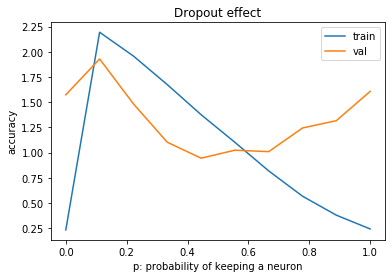

In [0]:
######################
# Plot the evolution of (train/val) accuracy through epochs
plt.plot(dropout_params,loss_train)
plt.plot(dropout_params,loss_test)
plt.title('Dropout effect')
plt.ylabel('accuracy')
plt.xlabel('p: probability of keeping a neuron')
plt.legend(['train', 'val'], loc='upper right')
plt.show()
# END TO DO 
######################


<a id='lr'></a>
# II - Learning rate

In [0]:
def cnn_model_lr(input_shape, num_classes,alpha):
    #CNN model with adjustable learning rate for the optimizer
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32,(3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
  
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
 
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(num_classes))

    model.add(Activation('softmax'))

    sgd = SGD(lr=alpha, decay=1.0e-6)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model



In [0]:
acc_train = []
acc_test = []
lr_params = [1e-6,0.01] #set of learning rate parameters

for alpha in lr_params:
  # we train the model for each value of the learning rate 
  model2 = cnn_model_lr(x_train.shape[1:], 10, alpha)
  ret2 = train_model(model2, x_train, y_train, batch_size= 32)
  acc_train.append(ret2.history['acc'])
  acc_test.append(ret2.history['val_acc'])

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
 - 9s - loss: 2.3007 - acc: 0.1171 - val_loss: 2.3016 - val_acc: 0.1163
Epoch 2/10


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 7s - loss: 2.3006 - acc: 0.1169 - val_loss: 2.3016 - val_acc: 0.1160
Epoch 3/10
 - 7s - loss: 2.3006 - acc: 0.1169 - val_loss: 2.3016 - val_acc: 0.1161
Epoch 4/10
 - 7s - loss: 2.3006 - acc: 0.1169 - val_loss: 2.3015 - val_acc: 0.1161
Epoch 5/10
 - 7s - loss: 2.3005 - acc: 0.1169 - val_loss: 2.3015 - val_acc: 0.1160
Epoch 6/10
 - 7s - loss: 2.3005 - acc: 0.1167 - val_loss: 2.3014 - val_acc: 0.1157
Epoch 7/10
 - 7s - loss: 2.3005 - acc: 0.1166 - val_loss: 2.3014 - val_acc: 0.1154
Epoch 8/10
 - 7s - loss: 2.3004 - acc: 0.1166 - val_loss: 2.3014 - val_acc: 0.1153
Epoch 9/10
 - 7s - loss: 2.3004 - acc: 0.1166 - val_loss: 2.3013 - val_acc: 0.1153
Epoch 10/10
 - 7s - loss: 2.3004 - acc: 0.1168 - val_loss: 2.3013 - val_acc: 0.1155
Train on 40000 samples, validate on 10000 samples
Epoch 1/10
 - 10s - loss: 2.0317 - acc: 0.2535 - val_loss: 1.7680 - val_acc: 0.3826
Epoch 2/10


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 7s - loss: 1.6249 - acc: 0.4176 - val_loss: 1.5007 - val_acc: 0.4603
Epoch 3/10
 - 7s - loss: 1.4211 - acc: 0.4931 - val_loss: 1.3791 - val_acc: 0.5088
Epoch 4/10
 - 7s - loss: 1.3032 - acc: 0.5358 - val_loss: 1.2839 - val_acc: 0.5389
Epoch 5/10
 - 7s - loss: 1.2040 - acc: 0.5705 - val_loss: 1.2326 - val_acc: 0.5616
Epoch 6/10
 - 7s - loss: 1.1170 - acc: 0.6051 - val_loss: 1.1909 - val_acc: 0.5796
Epoch 7/10
 - 7s - loss: 1.0293 - acc: 0.6377 - val_loss: 1.1109 - val_acc: 0.6139
Epoch 8/10
 - 7s - loss: 0.9471 - acc: 0.6689 - val_loss: 1.1201 - val_acc: 0.6156
Epoch 9/10
 - 7s - loss: 0.8673 - acc: 0.6975 - val_loss: 1.1393 - val_acc: 0.6127
Epoch 10/10
 - 8s - loss: 0.7881 - acc: 0.7237 - val_loss: 1.0684 - val_acc: 0.6388


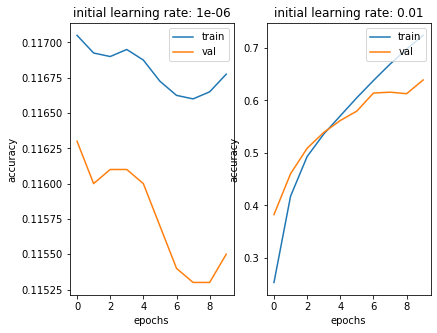

In [0]:
######################
# TO DO
# Plot the evolution of (train/val) accuracy through epochs
fig = plt.figure(figsize=(10,5))
for i in range(1,1+len(lr_params)):
  fig.add_subplot(1,3,i)
  plt.plot(acc_train[i-1])
  plt.plot(acc_test[i-1])
  plt.title('initial learning rate: '+str(lr_params[i-1]))
  plt.ylabel('accuracy')
  plt.xlabel('epochs')
  plt.legend(['train', 'val'], loc='upper right')
# END TO DO 
######################

######################

<a id='bn'></a>
# III - Batch Normalization

In [0]:
def cnn_model_bn(input_shape, num_classes):

    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(BatchNormalization()) #
    model.add(Activation('relu')) 

    model.add(Conv2D(32,(3, 3)))
    model.add(BatchNormalization()) #
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
  
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization()) #
    model.add(Activation('relu'))

    model.add(Conv2D(64, (3,3)))
    model.add(BatchNormalization()) #
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
 
    model.add(Flatten())
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    sgd = SGD(lr=0.1, decay=1.0e-6)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

def cnn_model_bn(input_shape, num_classes):

    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(BatchNormalization()) #
    model.add(Activation('relu')) 

    model.add(Conv2D(32,(3, 3)))
    model.add(BatchNormalization()) #
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
  
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization()) #
    model.add(Activation('relu'))

    model.add(Conv2D(64, (3,3)))
    model.add(BatchNormalization()) #
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
 
    model.add(Flatten())
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    sgd = SGD(lr=0.1, decay=1.0e-6)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

In [0]:
# Create the models
model = cnn_model(x_train.shape[1:], 10)
model_bn = cnn_model_bn(x_train.shape[1:], 10)

# Train the models
ret1 = train_model(model, x_train, y_train, batch_size= 32)
ret2 = train_model(model_bn, x_train, y_train, batch_size= 32)















Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 16s 392us/step - loss: 1.8527 - acc: 0.3283 - val_loss: 1.4745 - val_acc: 0.4701
Epoch 2/10
  832/40000 [..............................] - ETA: 8s - loss: 1.4622 - acc: 0.4736

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


40000/40000 [==============================] - 9s 224us/step - loss: 1.3365 - acc: 0.5212 - val_loss: 1.2445 - val_acc: 0.5601
Epoch 3/10
40000/40000 [==============================] - 9s 228us/step - loss: 1.0819 - acc: 0.6169 - val_loss: 1.0868 - val_acc: 0.6253
Epoch 4/10
40000/40000 [==============================] - 9s 235us/step - loss: 0.8837 - acc: 0.6906 - val_loss: 0.9902 - val_acc: 0.6564
Epoch 5/10
40000/40000 [==============================] - 9s 224us/step - loss: 0.7112 - acc: 0.7490 - val_loss: 1.0691 - val_acc: 0.6534
Epoch 6/10
40000/40000 [==============================] - 9s 232us/step - loss: 0.5530 - acc: 0.8066 - val_loss: 1.1199 - val_acc: 0.6555
Epoch 7/10
40000/40000 [==============================] - 9s 227us/step - loss: 0.4177 - acc: 0.8534 - val_loss: 1.2178 - val_acc: 0.6558
Epoch 8/10
40000/40000 [==============================] - 9s 228us/step - loss: 0.3315 - acc: 0.8833 - val_loss: 1.3130 - val_acc: 0.6668
Epoch 9/10
40000/40000 [=====================

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


40000/40000 [==============================] - 14s 339us/step - loss: 0.8299 - acc: 0.7080 - val_loss: 0.8893 - val_acc: 0.6915
Epoch 3/10
40000/40000 [==============================] - 14s 338us/step - loss: 0.6265 - acc: 0.7807 - val_loss: 0.7871 - val_acc: 0.7365
Epoch 4/10
40000/40000 [==============================] - 14s 351us/step - loss: 0.4812 - acc: 0.8323 - val_loss: 0.7718 - val_acc: 0.7449
Epoch 5/10
40000/40000 [==============================] - 14s 352us/step - loss: 0.3581 - acc: 0.8755 - val_loss: 0.8629 - val_acc: 0.7327
Epoch 6/10
40000/40000 [==============================] - 14s 345us/step - loss: 0.2593 - acc: 0.9106 - val_loss: 0.8785 - val_acc: 0.7404
Epoch 7/10
40000/40000 [==============================] - 14s 348us/step - loss: 0.1827 - acc: 0.9383 - val_loss: 0.9588 - val_acc: 0.7404
Epoch 8/10
40000/40000 [==============================] - 14s 348us/step - loss: 0.1289 - acc: 0.9591 - val_loss: 0.9428 - val_acc: 0.7525
Epoch 9/10
40000/40000 [==============

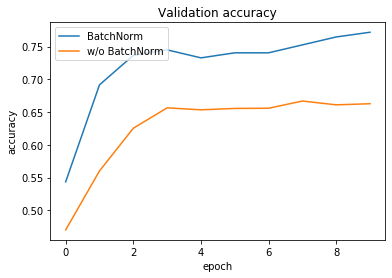

In [0]:
# Plot the evolution of validation accuracy through epochs
plt.plot(ret2.history['val_acc'])
plt.plot(ret1.history['val_acc'])

plt.title('Validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['BatchNorm', 'w/o BatchNorm'], loc='upper left')
plt.show()

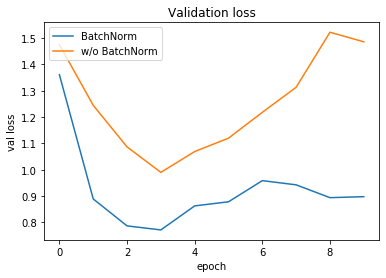

In [0]:
# Plot the evolution of validation loss through epochs
plt.plot(ret2.history['val_loss'])
plt.plot(ret1.history['val_loss'])

plt.title('Validation loss')
plt.ylabel('val loss')
plt.xlabel('epoch')
plt.legend(['BatchNorm', 'w/o BatchNorm'], loc='upper left')
plt.show()

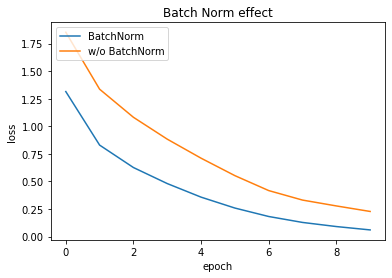

In [0]:
# Plot the evolution of train loss through epochs
plt.plot(ret2.history['loss'])
plt.plot(ret1.history['loss'])

plt.title('Batch Norm effect')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['BatchNorm', 'w/o BatchNorm'], loc='upper left')
plt.show()

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 34s 862us/step - loss: 0.7873 - acc: 0.7425 - val_loss: 0.7784 - val_acc: 0.7448
Epoch 2/10
  220/40000 [..............................] - ETA: 29s - loss: 0.4606 - acc: 0.8273

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


40000/40000 [==============================] - 34s 843us/step - loss: 0.4965 - acc: 0.8272 - val_loss: 0.8487 - val_acc: 0.7421
Epoch 3/10
40000/40000 [==============================] - 34s 853us/step - loss: 0.4125 - acc: 0.8558 - val_loss: 0.8191 - val_acc: 0.7559
Epoch 4/10
40000/40000 [==============================] - 34s 848us/step - loss: 0.3411 - acc: 0.8835 - val_loss: 0.8182 - val_acc: 0.7608
Epoch 5/10
40000/40000 [==============================] - 34s 857us/step - loss: 0.2994 - acc: 0.8958 - val_loss: 0.7959 - val_acc: 0.7731
Epoch 6/10
40000/40000 [==============================] - 34s 838us/step - loss: 0.2530 - acc: 0.9129 - val_loss: 0.8206 - val_acc: 0.7672
Epoch 7/10
40000/40000 [==============================] - 35s 875us/step - loss: 0.2233 - acc: 0.9236 - val_loss: 0.9243 - val_acc: 0.7617
Epoch 8/10
40000/40000 [==============================] - 34s 850us/step - loss: 0.1997 - acc: 0.9315 - val_loss: 0.8868 - val_acc: 0.7700
Epoch 9/10
40000/40000 [==============

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


40000/40000 [==============================] - 8s 200us/step - loss: 0.0105 - acc: 0.9990 - val_loss: 0.8241 - val_acc: 0.7950
Epoch 3/10
40000/40000 [==============================] - 8s 200us/step - loss: 0.0076 - acc: 0.9998 - val_loss: 0.8247 - val_acc: 0.7970
Epoch 4/10
40000/40000 [==============================] - 8s 201us/step - loss: 0.0064 - acc: 0.9999 - val_loss: 0.8274 - val_acc: 0.7996
Epoch 5/10
40000/40000 [==============================] - 8s 200us/step - loss: 0.0055 - acc: 0.9999 - val_loss: 0.8278 - val_acc: 0.7994
Epoch 6/10
40000/40000 [==============================] - 8s 201us/step - loss: 0.0049 - acc: 0.9999 - val_loss: 0.8314 - val_acc: 0.8012
Epoch 7/10
40000/40000 [==============================] - 8s 203us/step - loss: 0.0042 - acc: 1.0000 - val_loss: 0.8317 - val_acc: 0.8012
Epoch 8/10
40000/40000 [==============================] - 8s 203us/step - loss: 0.0040 - acc: 1.0000 - val_loss: 0.8362 - val_acc: 0.8004
Epoch 9/10
40000/40000 [=====================

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


40000/40000 [==============================] - 6s 143us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 0.8417 - val_acc: 0.8016
Epoch 3/10
40000/40000 [==============================] - 6s 142us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 0.8418 - val_acc: 0.8018
Epoch 4/10
40000/40000 [==============================] - 6s 142us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 0.8420 - val_acc: 0.8018
Epoch 5/10
40000/40000 [==============================] - 6s 143us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.8422 - val_acc: 0.8018
Epoch 6/10
40000/40000 [==============================] - 6s 143us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 0.8423 - val_acc: 0.8021
Epoch 7/10
40000/40000 [==============================] - 6s 143us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 0.8425 - val_acc: 0.8022
Epoch 8/10
40000/40000 [==============================] - 6s 143us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 0.8427 - val_acc: 0.8023
Epoch 9/10
40000/40000 [=====================

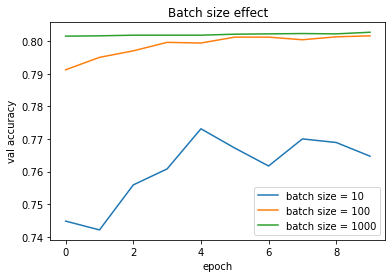

In [0]:
batch_size = [10,100,1000]

for s in batch_size:
  r = train_model(model_bn, x_train, y_train, batch_size= s)
  plt.plot(r.history['val_acc'])

plt.title('Batch size effect')
plt.ylabel('val accuracy')
plt.xlabel('epoch')
plt.legend(['batch size = 10','batch size = 100','batch size = 1000'])
plt.show()


Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 34s 843us/step - loss: 0.1444 - acc: 0.9495 - val_loss: 0.9835 - val_acc: 0.7605
Epoch 2/10
  190/40000 [..............................] - ETA: 34s - loss: 0.0928 - acc: 0.9737

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


40000/40000 [==============================] - 34s 855us/step - loss: 0.1398 - acc: 0.9513 - val_loss: 0.9691 - val_acc: 0.7737
Epoch 3/10
40000/40000 [==============================] - 34s 848us/step - loss: 0.1323 - acc: 0.9551 - val_loss: 0.9736 - val_acc: 0.7771
Epoch 4/10
40000/40000 [==============================] - 34s 854us/step - loss: 0.1268 - acc: 0.9574 - val_loss: 0.9762 - val_acc: 0.7710
Epoch 5/10
40000/40000 [==============================] - 34s 853us/step - loss: 0.1088 - acc: 0.9636 - val_loss: 1.0186 - val_acc: 0.7737
Epoch 6/10
40000/40000 [==============================] - 35s 869us/step - loss: 0.1083 - acc: 0.9635 - val_loss: 0.9920 - val_acc: 0.7730
Epoch 7/10
40000/40000 [==============================] - 35s 866us/step - loss: 0.1006 - acc: 0.9661 - val_loss: 0.9969 - val_acc: 0.7810
Epoch 8/10
40000/40000 [==============================] - 34s 847us/step - loss: 0.1000 - acc: 0.9660 - val_loss: 0.9961 - val_acc: 0.7785
Epoch 9/10
40000/40000 [==============

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


40000/40000 [==============================] - 8s 202us/step - loss: 0.0032 - acc: 0.9998 - val_loss: 0.9458 - val_acc: 0.7909
Epoch 3/10
40000/40000 [==============================] - 8s 200us/step - loss: 0.0025 - acc: 0.9998 - val_loss: 0.9447 - val_acc: 0.7916
Epoch 4/10
40000/40000 [==============================] - 8s 201us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 0.9443 - val_acc: 0.7919
Epoch 5/10
40000/40000 [==============================] - 8s 198us/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.9435 - val_acc: 0.7932
Epoch 6/10
40000/40000 [==============================] - 8s 201us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.9426 - val_acc: 0.7941
Epoch 7/10
40000/40000 [==============================] - 8s 201us/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.9452 - val_acc: 0.7945
Epoch 8/10
40000/40000 [==============================] - 8s 203us/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.9445 - val_acc: 0.7946
Epoch 9/10
40000/40000 [=====================

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


40000/40000 [==============================] - 6s 141us/step - loss: 6.5916e-04 - acc: 1.0000 - val_loss: 0.9469 - val_acc: 0.7955
Epoch 3/10
40000/40000 [==============================] - 6s 141us/step - loss: 6.6113e-04 - acc: 1.0000 - val_loss: 0.9471 - val_acc: 0.7957
Epoch 4/10
40000/40000 [==============================] - 6s 141us/step - loss: 6.5710e-04 - acc: 1.0000 - val_loss: 0.9472 - val_acc: 0.7959
Epoch 5/10
40000/40000 [==============================] - 6s 140us/step - loss: 6.5360e-04 - acc: 1.0000 - val_loss: 0.9473 - val_acc: 0.7959
Epoch 6/10
40000/40000 [==============================] - 6s 141us/step - loss: 6.5158e-04 - acc: 1.0000 - val_loss: 0.9474 - val_acc: 0.7960
Epoch 7/10
40000/40000 [==============================] - 6s 141us/step - loss: 6.4895e-04 - acc: 1.0000 - val_loss: 0.9475 - val_acc: 0.7960
Epoch 8/10
40000/40000 [==============================] - 6s 141us/step - loss: 6.3915e-04 - acc: 1.0000 - val_loss: 0.9476 - val_acc: 0.7960
Epoch 9/10
40000/

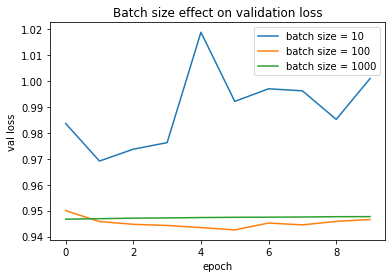

In [0]:
batch_size = [10,100,1000]

for s in batch_size:
  r = train_model(model_bn, x_train, y_train, batch_size= s)
  plt.plot(r.history['val_loss'])

plt.title('Batch size effect on validation loss')
plt.ylabel('val loss')
plt.xlabel('epoch')
plt.legend(['batch size = 10','batch size = 100','batch size = 1000'])
plt.show()

<a id='init'></a>
# IV - Initializations

In [0]:
def cnn_model_init(input_shape, num_classes, init_method = 'glorot_uniform'):
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape, kernel_initializer=init_method))
    model.add(Activation('relu'))
    model.add(Conv2D(32,(3, 3), kernel_initializer=init_method))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
  
    model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=init_method))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3,3), kernel_initializer=init_method))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
 
    model.add(Flatten())
    model.add(Dense(512, kernel_initializer=init_method))
    model.add(Activation('relu'))

    model.add(Dense(num_classes, kernel_initializer=init_method))
    model.add(Activation('softmax'))

    sgd = SGD(lr=0.1, decay=1.0e-6)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

## Constant vs Random Initialization

In [0]:
res1 = {}
for sig in [0.01, 0.03, 0.05, 0.07, 0.09]:
    print("=================sigma=",sig,"===================")
    init_method = RandomNormal(stddev=sig)
    model = cnn_model_init(x_train.shape[1:], 10, init_method = init_method)
    ret = train_model(model, x_train, y_train, batch_size= 32)
    res1['normal_'+str(sig)] = ret.history

    init_method = RandomUniform(minval=-np.sqrt(3)*sig, maxval=np.sqrt(3)*sig)
    model = cnn_model_init(x_train.shape[1:], 10, init_method = init_method)
    ret = train_model(model, x_train, y_train, batch_size= 32)
    res1['uniform_'+str(sig)] = ret.history

for init_method in ['zeros' , 'ones']:
    print("=================init_constant=",init_method,"===================")
    model = cnn_model_init(x_train.shape[1:], 10, init_method = init_method)
    ret = train_model(model, x_train, y_train, batch_size= 32)
    res1[init_method] = ret.history

=================sigma= 0.01 ===================
Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 9s 235us/step - loss: 2.3034 - acc: 0.1000 - val_loss: 2.3035 - val_acc: 0.0952
Epoch 2/10
  768/40000 [..............................] - ETA: 8s - loss: 2.3047 - acc: 0.1016

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


40000/40000 [==============================] - 9s 224us/step - loss: 2.3035 - acc: 0.0983 - val_loss: 2.3032 - val_acc: 0.0997
Epoch 3/10
40000/40000 [==============================] - 9s 218us/step - loss: 2.3032 - acc: 0.1001 - val_loss: 2.3031 - val_acc: 0.1003
Epoch 4/10
40000/40000 [==============================] - 9s 222us/step - loss: 2.3034 - acc: 0.0978 - val_loss: 2.3031 - val_acc: 0.1016
Epoch 5/10
40000/40000 [==============================] - 9s 226us/step - loss: 2.3034 - acc: 0.1007 - val_loss: 2.3036 - val_acc: 0.0977
Epoch 6/10
40000/40000 [==============================] - 9s 220us/step - loss: 2.3034 - acc: 0.0969 - val_loss: 2.3031 - val_acc: 0.1022
Epoch 7/10
40000/40000 [==============================] - 9s 224us/step - loss: 2.3034 - acc: 0.0970 - val_loss: 2.3027 - val_acc: 0.1016
Epoch 8/10
40000/40000 [==============================] - 9s 224us/step - loss: 2.3034 - acc: 0.0990 - val_loss: 2.3033 - val_acc: 0.0980
Epoch 9/10
40000/40000 [=====================

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


40000/40000 [==============================] - 9s 224us/step - loss: 2.3035 - acc: 0.0978 - val_loss: 2.3029 - val_acc: 0.0980
Epoch 3/10
40000/40000 [==============================] - 9s 228us/step - loss: 2.3033 - acc: 0.1001 - val_loss: 2.3042 - val_acc: 0.0977
Epoch 4/10
40000/40000 [==============================] - 9s 230us/step - loss: 2.3035 - acc: 0.0990 - val_loss: 2.3027 - val_acc: 0.0977
Epoch 5/10
40000/40000 [==============================] - 9s 218us/step - loss: 2.3034 - acc: 0.0977 - val_loss: 2.3034 - val_acc: 0.0997
Epoch 6/10
40000/40000 [==============================] - 9s 223us/step - loss: 2.3034 - acc: 0.1004 - val_loss: 2.3037 - val_acc: 0.0977
Epoch 7/10
40000/40000 [==============================] - 9s 221us/step - loss: 2.3033 - acc: 0.1000 - val_loss: 2.3035 - val_acc: 0.0977
Epoch 8/10
40000/40000 [==============================] - 9s 218us/step - loss: 2.3034 - acc: 0.0992 - val_loss: 2.3028 - val_acc: 0.0997
Epoch 9/10
40000/40000 [=====================

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


40000/40000 [==============================] - 9s 221us/step - loss: 1.5420 - acc: 0.4494 - val_loss: 1.3861 - val_acc: 0.5074
Epoch 3/10
40000/40000 [==============================] - 9s 224us/step - loss: 1.2531 - acc: 0.5531 - val_loss: 1.1749 - val_acc: 0.5825
Epoch 4/10
40000/40000 [==============================] - 9s 223us/step - loss: 1.0341 - acc: 0.6383 - val_loss: 1.0684 - val_acc: 0.6233
Epoch 5/10
40000/40000 [==============================] - 9s 223us/step - loss: 0.8469 - acc: 0.7023 - val_loss: 1.0478 - val_acc: 0.6433
Epoch 6/10
40000/40000 [==============================] - 9s 222us/step - loss: 0.6784 - acc: 0.7620 - val_loss: 1.1103 - val_acc: 0.6499
Epoch 7/10
40000/40000 [==============================] - 9s 224us/step - loss: 0.5203 - acc: 0.8175 - val_loss: 1.1099 - val_acc: 0.6577
Epoch 8/10
40000/40000 [==============================] - 9s 221us/step - loss: 0.3926 - acc: 0.8623 - val_loss: 1.3200 - val_acc: 0.6417
Epoch 9/10
40000/40000 [=====================

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


40000/40000 [==============================] - 9s 222us/step - loss: 1.5181 - acc: 0.4571 - val_loss: 1.3448 - val_acc: 0.5228
Epoch 3/10
40000/40000 [==============================] - 9s 220us/step - loss: 1.2220 - acc: 0.5650 - val_loss: 1.3521 - val_acc: 0.5308
Epoch 4/10
40000/40000 [==============================] - 9s 225us/step - loss: 1.0111 - acc: 0.6445 - val_loss: 1.0433 - val_acc: 0.6409
Epoch 5/10
40000/40000 [==============================] - 9s 224us/step - loss: 0.8329 - acc: 0.7086 - val_loss: 1.2965 - val_acc: 0.5985
Epoch 6/10
40000/40000 [==============================] - 9s 220us/step - loss: 0.6721 - acc: 0.7633 - val_loss: 1.0432 - val_acc: 0.6540
Epoch 7/10
40000/40000 [==============================] - 9s 220us/step - loss: 0.5329 - acc: 0.8115 - val_loss: 1.2366 - val_acc: 0.6416
Epoch 8/10
40000/40000 [==============================] - 9s 226us/step - loss: 0.4034 - acc: 0.8590 - val_loss: 1.2727 - val_acc: 0.6475
Epoch 9/10
40000/40000 [=====================

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


40000/40000 [==============================] - 9s 228us/step - loss: 1.4178 - acc: 0.4909 - val_loss: 1.3096 - val_acc: 0.5269
Epoch 3/10
40000/40000 [==============================] - 9s 221us/step - loss: 1.1818 - acc: 0.5798 - val_loss: 1.2459 - val_acc: 0.5626
Epoch 4/10
40000/40000 [==============================] - 9s 222us/step - loss: 1.0009 - acc: 0.6485 - val_loss: 1.1868 - val_acc: 0.5854
Epoch 5/10
40000/40000 [==============================] - 9s 225us/step - loss: 0.8337 - acc: 0.7084 - val_loss: 1.0711 - val_acc: 0.6433
Epoch 6/10
40000/40000 [==============================] - 9s 226us/step - loss: 0.6921 - acc: 0.7584 - val_loss: 1.2402 - val_acc: 0.6004
Epoch 7/10
40000/40000 [==============================] - 9s 224us/step - loss: 0.5564 - acc: 0.8046 - val_loss: 1.2011 - val_acc: 0.6421
Epoch 8/10
40000/40000 [==============================] - 10s 239us/step - loss: 0.4564 - acc: 0.8426 - val_loss: 1.2745 - val_acc: 0.6419
Epoch 9/10
40000/40000 [====================

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


40000/40000 [==============================] - 9s 226us/step - loss: 1.3743 - acc: 0.5097 - val_loss: 1.2501 - val_acc: 0.5537
Epoch 3/10
40000/40000 [==============================] - 9s 226us/step - loss: 1.1352 - acc: 0.5967 - val_loss: 1.2630 - val_acc: 0.5643
Epoch 4/10
40000/40000 [==============================] - 9s 224us/step - loss: 0.9590 - acc: 0.6617 - val_loss: 1.1182 - val_acc: 0.6160
Epoch 5/10
40000/40000 [==============================] - 9s 224us/step - loss: 0.8162 - acc: 0.7121 - val_loss: 1.0430 - val_acc: 0.6409
Epoch 6/10
40000/40000 [==============================] - 9s 223us/step - loss: 0.6825 - acc: 0.7592 - val_loss: 1.2318 - val_acc: 0.6057
Epoch 7/10
40000/40000 [==============================] - 9s 225us/step - loss: 0.5542 - acc: 0.8047 - val_loss: 1.3011 - val_acc: 0.6186
Epoch 8/10
40000/40000 [==============================] - 9s 226us/step - loss: 0.4566 - acc: 0.8411 - val_loss: 1.3173 - val_acc: 0.6463
Epoch 9/10
40000/40000 [=====================

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


40000/40000 [==============================] - 9s 226us/step - loss: 1.5148 - acc: 0.4560 - val_loss: 1.4310 - val_acc: 0.4829
Epoch 3/10
40000/40000 [==============================] - 9s 225us/step - loss: 1.2733 - acc: 0.5484 - val_loss: 1.3145 - val_acc: 0.5284
Epoch 4/10
40000/40000 [==============================] - 9s 228us/step - loss: 1.1005 - acc: 0.6115 - val_loss: 1.1009 - val_acc: 0.6150
Epoch 5/10
40000/40000 [==============================] - 9s 222us/step - loss: 0.9606 - acc: 0.6644 - val_loss: 1.1085 - val_acc: 0.6194
Epoch 6/10
40000/40000 [==============================] - 9s 221us/step - loss: 0.8299 - acc: 0.7101 - val_loss: 1.1023 - val_acc: 0.6350
Epoch 7/10
40000/40000 [==============================] - 9s 225us/step - loss: 0.7193 - acc: 0.7499 - val_loss: 1.0755 - val_acc: 0.6451
Epoch 8/10
40000/40000 [==============================] - 9s 221us/step - loss: 0.6185 - acc: 0.7861 - val_loss: 1.1992 - val_acc: 0.6428
Epoch 9/10
40000/40000 [=====================

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


40000/40000 [==============================] - 9s 224us/step - loss: 1.4699 - acc: 0.4728 - val_loss: 1.3194 - val_acc: 0.5301
Epoch 3/10
40000/40000 [==============================] - 9s 222us/step - loss: 1.2162 - acc: 0.5688 - val_loss: 1.1773 - val_acc: 0.5795
Epoch 4/10
40000/40000 [==============================] - 9s 228us/step - loss: 1.0406 - acc: 0.6315 - val_loss: 1.0643 - val_acc: 0.6313
Epoch 5/10
40000/40000 [==============================] - 9s 224us/step - loss: 0.9075 - acc: 0.6784 - val_loss: 1.1181 - val_acc: 0.6248
Epoch 6/10
40000/40000 [==============================] - 9s 224us/step - loss: 0.7842 - acc: 0.7207 - val_loss: 1.1378 - val_acc: 0.6330
Epoch 7/10
40000/40000 [==============================] - 9s 224us/step - loss: 0.6742 - acc: 0.7632 - val_loss: 1.0896 - val_acc: 0.6524
Epoch 8/10
40000/40000 [==============================] - 9s 228us/step - loss: 0.5757 - acc: 0.7991 - val_loss: 1.2645 - val_acc: 0.6417
Epoch 9/10
40000/40000 [=====================

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


40000/40000 [==============================] - 10s 239us/step - loss: 14.5051 - acc: 0.1001 - val_loss: 14.5109 - val_acc: 0.0997
Epoch 3/10
40000/40000 [==============================] - 9s 224us/step - loss: 14.5051 - acc: 0.1001 - val_loss: 14.5109 - val_acc: 0.0997
Epoch 4/10
40000/40000 [==============================] - 9s 226us/step - loss: 14.5051 - acc: 0.1001 - val_loss: 14.5109 - val_acc: 0.0997
Epoch 5/10
40000/40000 [==============================] - 9s 226us/step - loss: 14.5051 - acc: 0.1001 - val_loss: 14.5109 - val_acc: 0.0997
Epoch 6/10
40000/40000 [==============================] - 9s 226us/step - loss: 14.5051 - acc: 0.1001 - val_loss: 14.5109 - val_acc: 0.0997
Epoch 7/10
40000/40000 [==============================] - 9s 229us/step - loss: 14.5051 - acc: 0.1001 - val_loss: 14.5109 - val_acc: 0.0997
Epoch 8/10
40000/40000 [==============================] - 9s 229us/step - loss: 14.5051 - acc: 0.1001 - val_loss: 14.5109 - val_acc: 0.0997
Epoch 9/10
40000/40000 [======

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


40000/40000 [==============================] - 9s 226us/step - loss: 2.3037 - acc: 0.1001 - val_loss: 2.3034 - val_acc: 0.1003
Epoch 3/10
40000/40000 [==============================] - 9s 229us/step - loss: 2.3037 - acc: 0.0969 - val_loss: 2.3039 - val_acc: 0.0952
Epoch 4/10
40000/40000 [==============================] - 9s 229us/step - loss: 2.3037 - acc: 0.0989 - val_loss: 2.3033 - val_acc: 0.0980
Epoch 5/10
40000/40000 [==============================] - 9s 231us/step - loss: 2.3036 - acc: 0.0955 - val_loss: 2.3043 - val_acc: 0.0977
Epoch 6/10
40000/40000 [==============================] - 9s 229us/step - loss: 2.3034 - acc: 0.0978 - val_loss: 2.3033 - val_acc: 0.1016
Epoch 7/10
40000/40000 [==============================] - 9s 229us/step - loss: 2.3034 - acc: 0.0994 - val_loss: 2.3032 - val_acc: 0.0980
Epoch 8/10
40000/40000 [==============================] - 9s 225us/step - loss: 2.3034 - acc: 0.1007 - val_loss: 2.3032 - val_acc: 0.1022
Epoch 9/10
40000/40000 [=====================

NameError: ignored

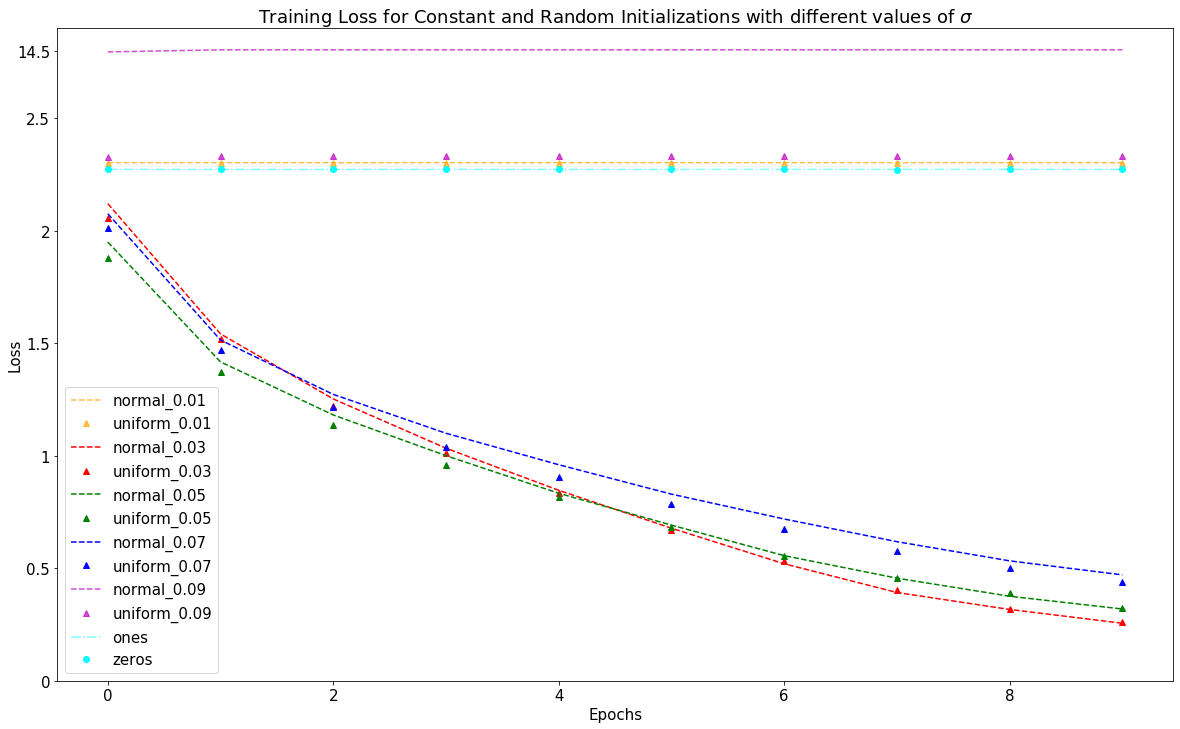

In [0]:
plt.figure(figsize=(20,12))
plt.rcParams.update({'font.size': 15})

colors = ['orange', 'r', 'green', 'blue', 'm', 'cyan', 'yellow', 'k']
res_dict = res1
metric = 'loss'
for i, sig in enumerate([0.01, 0.03, 0.05, 0.07, 0.09]):
  if i == 0 or i == 4:
    opt = 0.7
  else:
    opt = 1

  for method in ['normal_'+str(sig), 'uniform_'+str(sig)]:
    if 'normal' in method:
      if '0.09' in method:
        l1, = plt.plot(np.array(res_dict[method][metric]) - 11.7, '--', c = colors[i], label = method, alpha = opt)
      else:
        l1, = plt.plot(res_dict[method][metric], '--', c = colors[i], label = method, alpha = opt)
    else:
      if '0.09' in method:
        l1, = plt.plot(np.array(res_dict[method][metric]) + 0.03, '^', c = colors[i], label = method, alpha = opt)
      else:
        l1, = plt.plot(res_dict[method][metric], '^', c = colors[i], label = method, alpha = opt)

plt.plot(np.array(res_dict['ones'][metric])-0.03, '-.', c = colors[i+1], label = 'ones', alpha = 0.5)
plt.plot(np.array(res_dict['zeros'][metric])-0.03, 'o', c = colors[i+1], label = 'zeros', alpha = 1)

plt.text(-0.8,2.77,'14.5' )
plt.yticks([0,0.5,1,1.5,2,2.5,2.8],['0','0.5','1','1.5','2','2.5',''])
plt.ylim([0,2.9])
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss for Constant and Random Initializations with different values of $\sigma$')
plt.show()

## Random Initialization Methods

In [0]:
res2 = {}
for init_method in ['random_normal','lecun_normal','glorot_normal','he_normal']:
    print("====================init_method=",init_method,"=====================")
    model = cnn_model_init(x_train.shape[1:], 10, init_method = init_method)
    ret = train_model(model, x_train, y_train, batch_size= 32)
    res2[init_method] = ret.history

====================init_method= random_normal =====================
Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 10s 259us/step - loss: 2.0336 - acc: 0.2572 - val_loss: 1.6595 - val_acc: 0.4035
Epoch 2/10
  736/40000 [..............................] - ETA: 9s - loss: 1.5983 - acc: 0.3940

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


40000/40000 [==============================] - 9s 229us/step - loss: 1.4786 - acc: 0.4689 - val_loss: 1.3853 - val_acc: 0.4972
Epoch 3/10
40000/40000 [==============================] - 9s 230us/step - loss: 1.2365 - acc: 0.5607 - val_loss: 1.3085 - val_acc: 0.5400
Epoch 4/10
40000/40000 [==============================] - 9s 231us/step - loss: 1.0596 - acc: 0.6271 - val_loss: 1.1248 - val_acc: 0.6072
Epoch 5/10
40000/40000 [==============================] - 9s 231us/step - loss: 0.9031 - acc: 0.6808 - val_loss: 1.1038 - val_acc: 0.6277
Epoch 6/10
40000/40000 [==============================] - 9s 232us/step - loss: 0.7565 - acc: 0.7348 - val_loss: 1.0655 - val_acc: 0.6464
Epoch 7/10
40000/40000 [==============================] - 9s 232us/step - loss: 0.6239 - acc: 0.7812 - val_loss: 1.1411 - val_acc: 0.6384
Epoch 8/10
40000/40000 [==============================] - 9s 236us/step - loss: 0.5093 - acc: 0.8209 - val_loss: 1.3240 - val_acc: 0.6275
Epoch 9/10
40000/40000 [=====================

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


40000/40000 [==============================] - 9s 228us/step - loss: 1.2626 - acc: 0.5485 - val_loss: 1.0801 - val_acc: 0.6192
Epoch 3/10
40000/40000 [==============================] - 9s 233us/step - loss: 0.9902 - acc: 0.6516 - val_loss: 1.0371 - val_acc: 0.6327
Epoch 4/10
40000/40000 [==============================] - 10s 238us/step - loss: 0.7870 - acc: 0.7251 - val_loss: 0.9182 - val_acc: 0.6875
Epoch 5/10
40000/40000 [==============================] - 10s 238us/step - loss: 0.6127 - acc: 0.7848 - val_loss: 0.9181 - val_acc: 0.6938
Epoch 6/10
40000/40000 [==============================] - 9s 233us/step - loss: 0.4574 - acc: 0.8397 - val_loss: 1.0760 - val_acc: 0.6808
Epoch 7/10
40000/40000 [==============================] - 10s 238us/step - loss: 0.3388 - acc: 0.8807 - val_loss: 1.1242 - val_acc: 0.6901
Epoch 8/10
40000/40000 [==============================] - 10s 240us/step - loss: 0.2671 - acc: 0.9075 - val_loss: 1.2409 - val_acc: 0.6884
Epoch 9/10
40000/40000 [=================

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


40000/40000 [==============================] - 10s 238us/step - loss: 1.3117 - acc: 0.5297 - val_loss: 1.1401 - val_acc: 0.6000
Epoch 3/10
40000/40000 [==============================] - 9s 234us/step - loss: 1.0538 - acc: 0.6267 - val_loss: 1.0127 - val_acc: 0.6436
Epoch 4/10
40000/40000 [==============================] - 9s 237us/step - loss: 0.8509 - acc: 0.7008 - val_loss: 0.9528 - val_acc: 0.6804
Epoch 5/10
40000/40000 [==============================] - 9s 236us/step - loss: 0.6792 - acc: 0.7625 - val_loss: 1.0313 - val_acc: 0.6658
Epoch 6/10
40000/40000 [==============================] - 9s 233us/step - loss: 0.5247 - acc: 0.8165 - val_loss: 1.0886 - val_acc: 0.6734
Epoch 7/10
40000/40000 [==============================] - 9s 233us/step - loss: 0.3999 - acc: 0.8615 - val_loss: 1.2140 - val_acc: 0.6657
Epoch 8/10
40000/40000 [==============================] - 10s 239us/step - loss: 0.3116 - acc: 0.8933 - val_loss: 1.3392 - val_acc: 0.6736
Epoch 9/10
40000/40000 [===================

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


40000/40000 [==============================] - 9s 235us/step - loss: 1.1893 - acc: 0.5765 - val_loss: 1.0837 - val_acc: 0.6204
Epoch 3/10
40000/40000 [==============================] - 9s 236us/step - loss: 0.9363 - acc: 0.6703 - val_loss: 0.9823 - val_acc: 0.6541
Epoch 4/10
40000/40000 [==============================] - 9s 235us/step - loss: 0.7477 - acc: 0.7391 - val_loss: 0.9928 - val_acc: 0.6598
Epoch 5/10
40000/40000 [==============================] - 9s 235us/step - loss: 0.5873 - acc: 0.7962 - val_loss: 0.9536 - val_acc: 0.6958
Epoch 6/10
40000/40000 [==============================] - 9s 235us/step - loss: 0.4556 - acc: 0.8400 - val_loss: 1.0089 - val_acc: 0.6905
Epoch 7/10
40000/40000 [==============================] - 9s 237us/step - loss: 0.3411 - acc: 0.8833 - val_loss: 1.2349 - val_acc: 0.6609
Epoch 8/10
40000/40000 [==============================] - 9s 235us/step - loss: 0.2853 - acc: 0.9002 - val_loss: 1.2474 - val_acc: 0.6841
Epoch 9/10
40000/40000 [=====================

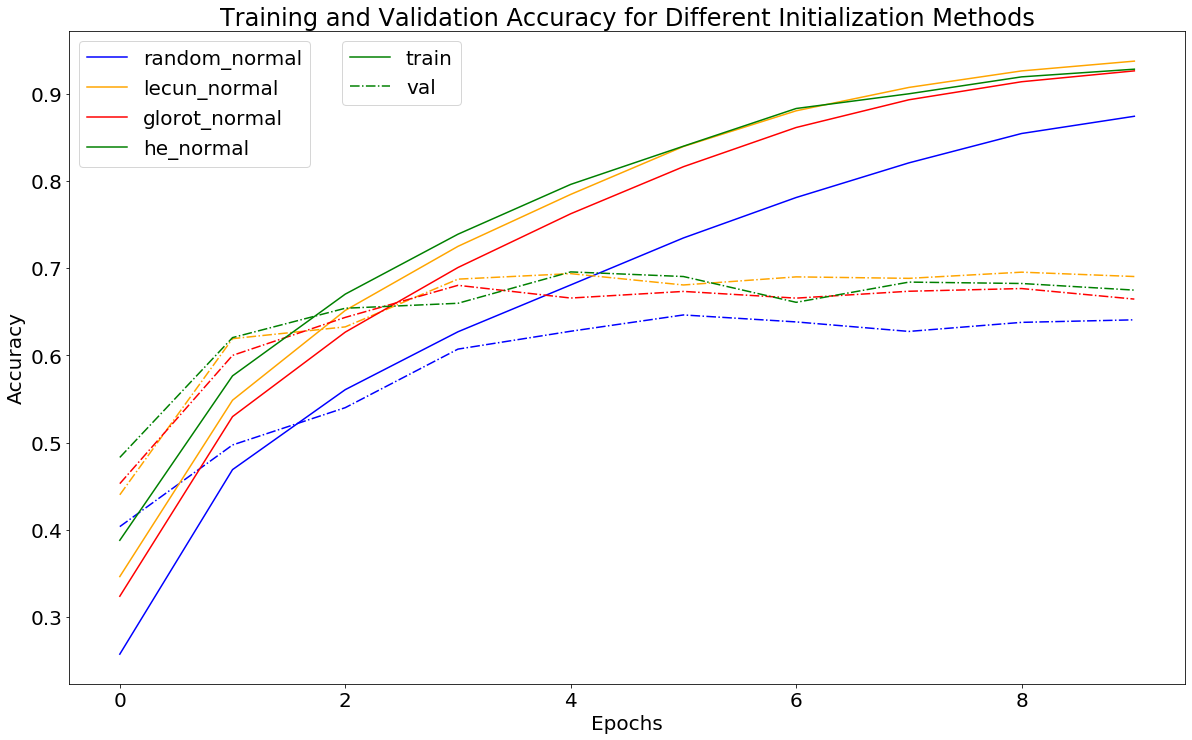

In [0]:
plt.figure(figsize=(20,12))
plt.rcParams.update({'font.size': 20})

colors = ['blue', 'orange', 'r', 'green', 'yellow', 'cyan', 'm', 'k']
res_dict = res2
for i, method in enumerate(res_dict):
    l1, = plt.plot(res_dict[method]['acc'], c = colors[i], label = method)
    l2, = plt.plot(res_dict[method]['val_acc'], '-.', c = colors[i])

legend1 = plt.legend([l1, l2], ["train", "val"], loc='upper right', bbox_to_anchor=(0.36, 1))

plt.gca().add_artist(legend1)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Different Initialization Methods')
plt.show()

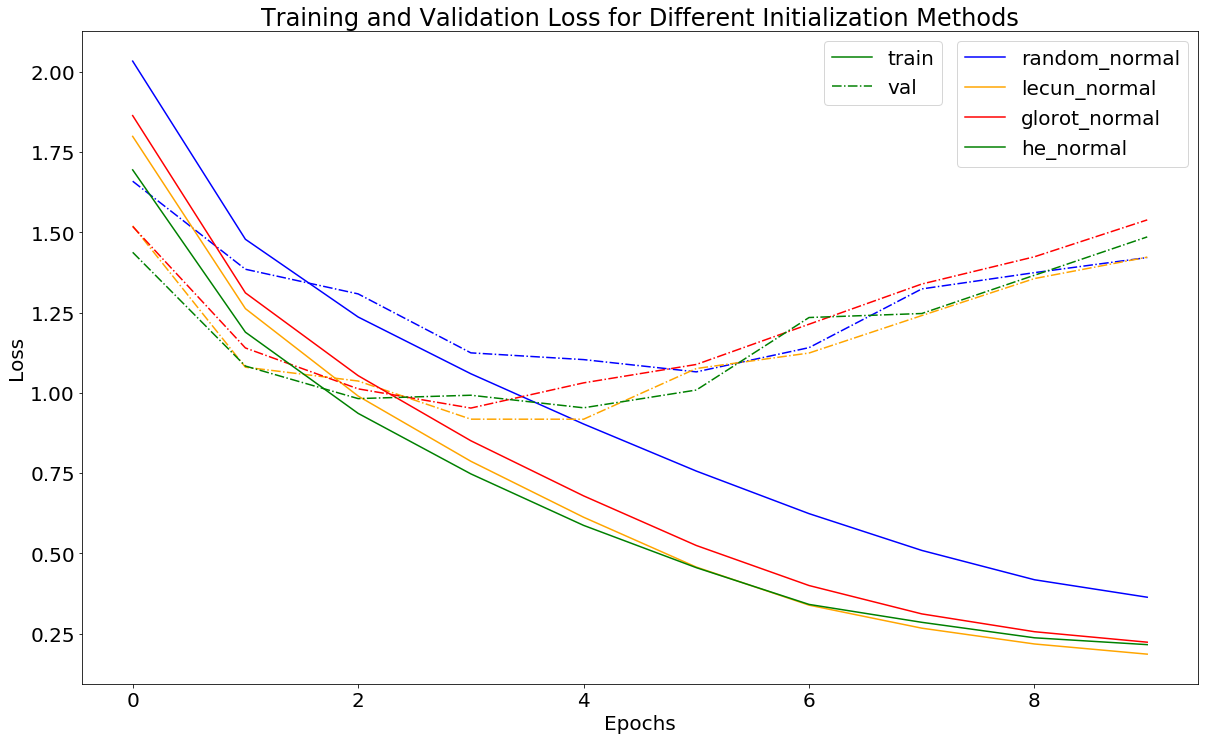

In [0]:
plt.figure(figsize=(20,12))
plt.rcParams.update({'font.size': 20})

colors = ['blue', 'orange', 'r', 'green', 'yellow', 'cyan', 'm', 'k']
res_dict = res2
for i, method in enumerate(res_dict):
    l1, = plt.plot(res_dict[method]['loss'], c = colors[i], label = method)
    l2, = plt.plot(res_dict[method]['val_loss'], '-.', c = colors[i])

legend1 = plt.legend([l1, l2], ["train", "val"], loc='upper right', bbox_to_anchor=(0.78, 1))

plt.gca().add_artist(legend1)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Different Initialization Methods')
plt.show()

<a id='decay'></a>
# V - Weight Decay

In [0]:
def cnn_model_decay(input_shape, num_classes, decay_cst = 0):
    model = Sequential()
    
    if decay_cst == 0:
        model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    else:
        model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape, activity_regularizer=regularizers.l2(decay_cst)))
    model.add(Activation('relu'))

    if decay_cst == 0:
        model.add(Conv2D(32,(3, 3)))
    else:
        model.add(Conv2D(32,(3, 3), activity_regularizer=regularizers.l2(decay_cst)))
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))
  
    if decay_cst == 0:
        model.add(Conv2D(64, (3, 3), padding='same'))
    else:
        model.add(Conv2D(64, (3, 3), padding='same', activity_regularizer=regularizers.l2(decay_cst)))
    model.add(Activation('relu'))

    if decay_cst == 0:
        model.add(Conv2D(64, (3,3)))
    else:
        model.add(Conv2D(64, (3,3), activity_regularizer=regularizers.l2(decay_cst)))
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))
 
    model.add(Flatten())

    if decay_cst == 0:
        model.add(Dense(512))
    else:
        model.add(Dense(512, activity_regularizer=regularizers.l2(decay_cst)))
    model.add(Activation('relu'))

    if decay_cst == 0:
        model.add(Dense(num_classes))
    else:
        model.add(Dense(num_classes, activity_regularizer=regularizers.l2(decay_cst)))
    model.add(Activation('softmax'))

    sgd = SGD(lr=0.1, decay=1.0e-6)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

In [0]:
res3 = {}
for lbda in [0.0, 1e-08, 5e-08, 1e-07, 5e-07, 1e-06, 5e-06, 1e-05, 2e-05]:
    print("================lbda=",lbda,"====================")
    model = cnn_model_decay(x_train.shape[1:], 10, decay_cst = lbda)
    ret = train_model(model, x_train, y_train, batch_size= 32)
    res3['lbda_'+str(lbda)] = ret.history

================lbda= 0.0 ====================
Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 11s 268us/step - loss: 1.8228 - acc: 0.3405 - val_loss: 1.4475 - val_acc: 0.4876
Epoch 2/10
  736/40000 [..............................] - ETA: 9s - loss: 1.3759 - acc: 0.4973

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


40000/40000 [==============================] - 9s 234us/step - loss: 1.2956 - acc: 0.5375 - val_loss: 1.2632 - val_acc: 0.5576
Epoch 3/10
40000/40000 [==============================] - 9s 235us/step - loss: 1.0352 - acc: 0.6330 - val_loss: 1.0241 - val_acc: 0.6370
Epoch 4/10
40000/40000 [==============================] - 9s 236us/step - loss: 0.8407 - acc: 0.7035 - val_loss: 0.9780 - val_acc: 0.6739
Epoch 5/10
40000/40000 [==============================] - 9s 236us/step - loss: 0.6565 - acc: 0.7711 - val_loss: 1.0034 - val_acc: 0.6673
Epoch 6/10
40000/40000 [==============================] - 9s 234us/step - loss: 0.5012 - acc: 0.8252 - val_loss: 1.0979 - val_acc: 0.6657
Epoch 7/10
40000/40000 [==============================] - 10s 239us/step - loss: 0.3848 - acc: 0.8648 - val_loss: 1.2157 - val_acc: 0.6586
Epoch 8/10
40000/40000 [==============================] - 10s 241us/step - loss: 0.2877 - acc: 0.9007 - val_loss: 1.4163 - val_acc: 0.6661
Epoch 9/10
40000/40000 [===================

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


40000/40000 [==============================] - 11s 265us/step - loss: 1.3609 - acc: 0.5153 - val_loss: 1.2515 - val_acc: 0.5673
Epoch 3/10
40000/40000 [==============================] - 10s 260us/step - loss: 1.1057 - acc: 0.6115 - val_loss: 1.1192 - val_acc: 0.6067
Epoch 4/10
40000/40000 [==============================] - 10s 259us/step - loss: 0.8936 - acc: 0.6915 - val_loss: 1.0240 - val_acc: 0.6491
Epoch 5/10
40000/40000 [==============================] - 10s 256us/step - loss: 0.7164 - acc: 0.7557 - val_loss: 0.9743 - val_acc: 0.6815
Epoch 6/10
40000/40000 [==============================] - 10s 257us/step - loss: 0.5545 - acc: 0.8130 - val_loss: 1.1096 - val_acc: 0.6530
Epoch 7/10
40000/40000 [==============================] - 10s 257us/step - loss: 0.4045 - acc: 0.8680 - val_loss: 1.1238 - val_acc: 0.6816
Epoch 8/10
40000/40000 [==============================] - 10s 256us/step - loss: 0.3006 - acc: 0.9067 - val_loss: 1.3846 - val_acc: 0.6660
Epoch 9/10
40000/40000 [==============

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


40000/40000 [==============================] - 10s 258us/step - loss: 1.3041 - acc: 0.5421 - val_loss: 1.1545 - val_acc: 0.5915
Epoch 3/10
40000/40000 [==============================] - 10s 262us/step - loss: 1.0538 - acc: 0.6392 - val_loss: 1.0617 - val_acc: 0.6365
Epoch 4/10
40000/40000 [==============================] - 10s 261us/step - loss: 0.8592 - acc: 0.7080 - val_loss: 1.0599 - val_acc: 0.6531
Epoch 5/10
40000/40000 [==============================] - 10s 261us/step - loss: 0.7024 - acc: 0.7665 - val_loss: 0.9643 - val_acc: 0.6940
Epoch 6/10
40000/40000 [==============================] - 10s 259us/step - loss: 0.5557 - acc: 0.8222 - val_loss: 0.9317 - val_acc: 0.7153
Epoch 7/10
40000/40000 [==============================] - 10s 260us/step - loss: 0.4262 - acc: 0.8720 - val_loss: 0.9876 - val_acc: 0.7126
Epoch 8/10
40000/40000 [==============================] - 10s 261us/step - loss: 0.3119 - acc: 0.9124 - val_loss: 1.0701 - val_acc: 0.7131
Epoch 9/10
40000/40000 [==============

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


40000/40000 [==============================] - 11s 263us/step - loss: 1.4395 - acc: 0.4899 - val_loss: 1.2315 - val_acc: 0.5667
Epoch 3/10
40000/40000 [==============================] - 10s 260us/step - loss: 1.1769 - acc: 0.5969 - val_loss: 1.1729 - val_acc: 0.6021
Epoch 4/10
40000/40000 [==============================] - 10s 260us/step - loss: 0.9885 - acc: 0.6687 - val_loss: 1.1653 - val_acc: 0.6085
Epoch 5/10
40000/40000 [==============================] - 11s 265us/step - loss: 0.8315 - acc: 0.7273 - val_loss: 0.9910 - val_acc: 0.6751
Epoch 6/10
40000/40000 [==============================] - 10s 261us/step - loss: 0.6920 - acc: 0.7802 - val_loss: 0.9698 - val_acc: 0.6914
Epoch 7/10
40000/40000 [==============================] - 11s 264us/step - loss: 0.5585 - acc: 0.8268 - val_loss: 0.9993 - val_acc: 0.7006
Epoch 8/10
40000/40000 [==============================] - 10s 262us/step - loss: 0.4477 - acc: 0.8699 - val_loss: 1.0139 - val_acc: 0.6983
Epoch 9/10
40000/40000 [==============

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


40000/40000 [==============================] - 10s 262us/step - loss: 1.4400 - acc: 0.5078 - val_loss: 1.2962 - val_acc: 0.5508
Epoch 3/10
40000/40000 [==============================] - 10s 259us/step - loss: 1.1839 - acc: 0.6066 - val_loss: 1.2901 - val_acc: 0.5770
Epoch 4/10
40000/40000 [==============================] - 11s 264us/step - loss: 1.0190 - acc: 0.6716 - val_loss: 0.9993 - val_acc: 0.6825
Epoch 5/10
40000/40000 [==============================] - 10s 257us/step - loss: 0.8817 - acc: 0.7247 - val_loss: 0.9238 - val_acc: 0.7212
Epoch 6/10
40000/40000 [==============================] - 10s 256us/step - loss: 0.7769 - acc: 0.7681 - val_loss: 0.9090 - val_acc: 0.7215
Epoch 7/10
40000/40000 [==============================] - 11s 267us/step - loss: 0.6689 - acc: 0.8058 - val_loss: 0.9674 - val_acc: 0.7099
Epoch 8/10
40000/40000 [==============================] - 10s 260us/step - loss: 0.5802 - acc: 0.8381 - val_loss: 0.9650 - val_acc: 0.7155
Epoch 9/10
40000/40000 [==============

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


40000/40000 [==============================] - 10s 260us/step - loss: 1.5153 - acc: 0.4886 - val_loss: 1.3225 - val_acc: 0.5736
Epoch 3/10
40000/40000 [==============================] - 11s 263us/step - loss: 1.2684 - acc: 0.5887 - val_loss: 1.1140 - val_acc: 0.6395
Epoch 4/10
40000/40000 [==============================] - 10s 261us/step - loss: 1.0957 - acc: 0.6541 - val_loss: 1.1801 - val_acc: 0.6222
Epoch 5/10
40000/40000 [==============================] - 10s 262us/step - loss: 0.9763 - acc: 0.7032 - val_loss: 1.0258 - val_acc: 0.6922
Epoch 6/10
40000/40000 [==============================] - 10s 262us/step - loss: 0.8608 - acc: 0.7464 - val_loss: 0.9516 - val_acc: 0.7101
Epoch 7/10
40000/40000 [==============================] - 10s 262us/step - loss: 0.7762 - acc: 0.7792 - val_loss: 0.9284 - val_acc: 0.7257
Epoch 8/10
40000/40000 [==============================] - 10s 262us/step - loss: 0.7041 - acc: 0.8061 - val_loss: 1.0661 - val_acc: 0.7100
Epoch 9/10
40000/40000 [==============

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


40000/40000 [==============================] - 10s 259us/step - loss: 1.6833 - acc: 0.4573 - val_loss: 1.5055 - val_acc: 0.5183
Epoch 3/10
40000/40000 [==============================] - 11s 265us/step - loss: 1.4887 - acc: 0.5434 - val_loss: 1.3831 - val_acc: 0.5850
Epoch 4/10
40000/40000 [==============================] - 10s 259us/step - loss: 1.3606 - acc: 0.5972 - val_loss: 1.7593 - val_acc: 0.5375
Epoch 5/10
40000/40000 [==============================] - 10s 261us/step - loss: 1.2759 - acc: 0.6358 - val_loss: 1.3810 - val_acc: 0.6130
Epoch 6/10
40000/40000 [==============================] - 11s 269us/step - loss: 1.1912 - acc: 0.6725 - val_loss: 1.2197 - val_acc: 0.6631
Epoch 7/10
40000/40000 [==============================] - 10s 262us/step - loss: 1.1380 - acc: 0.6998 - val_loss: 1.2670 - val_acc: 0.6615
Epoch 8/10
40000/40000 [==============================] - 10s 260us/step - loss: 1.0664 - acc: 0.7233 - val_loss: 1.2110 - val_acc: 0.6825
Epoch 9/10
40000/40000 [==============

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


40000/40000 [==============================] - 11s 270us/step - loss: 1.9098 - acc: 0.3937 - val_loss: 1.7790 - val_acc: 0.4360
Epoch 3/10
40000/40000 [==============================] - 10s 261us/step - loss: 1.7340 - acc: 0.4810 - val_loss: 1.6456 - val_acc: 0.5145
Epoch 4/10
40000/40000 [==============================] - 10s 260us/step - loss: 1.6271 - acc: 0.5320 - val_loss: 1.4274 - val_acc: 0.5795
Epoch 5/10
40000/40000 [==============================] - 11s 266us/step - loss: 1.5624 - acc: 0.5696 - val_loss: 1.5043 - val_acc: 0.5791
Epoch 6/10
40000/40000 [==============================] - 11s 264us/step - loss: 1.5165 - acc: 0.5991 - val_loss: 1.4421 - val_acc: 0.5954
Epoch 7/10
40000/40000 [==============================] - 10s 261us/step - loss: 1.4480 - acc: 0.6291 - val_loss: 1.8486 - val_acc: 0.5631
Epoch 8/10
40000/40000 [==============================] - 11s 265us/step - loss: 1.4083 - acc: 0.6485 - val_loss: 1.3936 - val_acc: 0.6345
Epoch 9/10
40000/40000 [==============

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


40000/40000 [==============================] - 10s 261us/step - loss: 2.2225 - acc: 0.3094 - val_loss: 1.9509 - val_acc: 0.3926
Epoch 3/10
40000/40000 [==============================] - 11s 263us/step - loss: 2.1704 - acc: 0.3947 - val_loss: 2.0279 - val_acc: 0.4023
Epoch 4/10
40000/40000 [==============================] - 11s 267us/step - loss: 2.1501 - acc: 0.4469 - val_loss: 2.0887 - val_acc: 0.4718
Epoch 5/10
40000/40000 [==============================] - 11s 265us/step - loss: 2.1759 - acc: 0.4887 - val_loss: 1.7708 - val_acc: 0.5064
Epoch 6/10
40000/40000 [==============================] - 11s 265us/step - loss: nan - acc: 0.2798 - val_loss: nan - val_acc: 0.1003
Epoch 7/10
40000/40000 [==============================] - 11s 266us/step - loss: nan - acc: 0.0999 - val_loss: nan - val_acc: 0.1003
Epoch 8/10
40000/40000 [==============================] - 11s 263us/step - loss: nan - acc: 0.0999 - val_loss: nan - val_acc: 0.1003
Epoch 9/10
40000/40000 [==============================] 

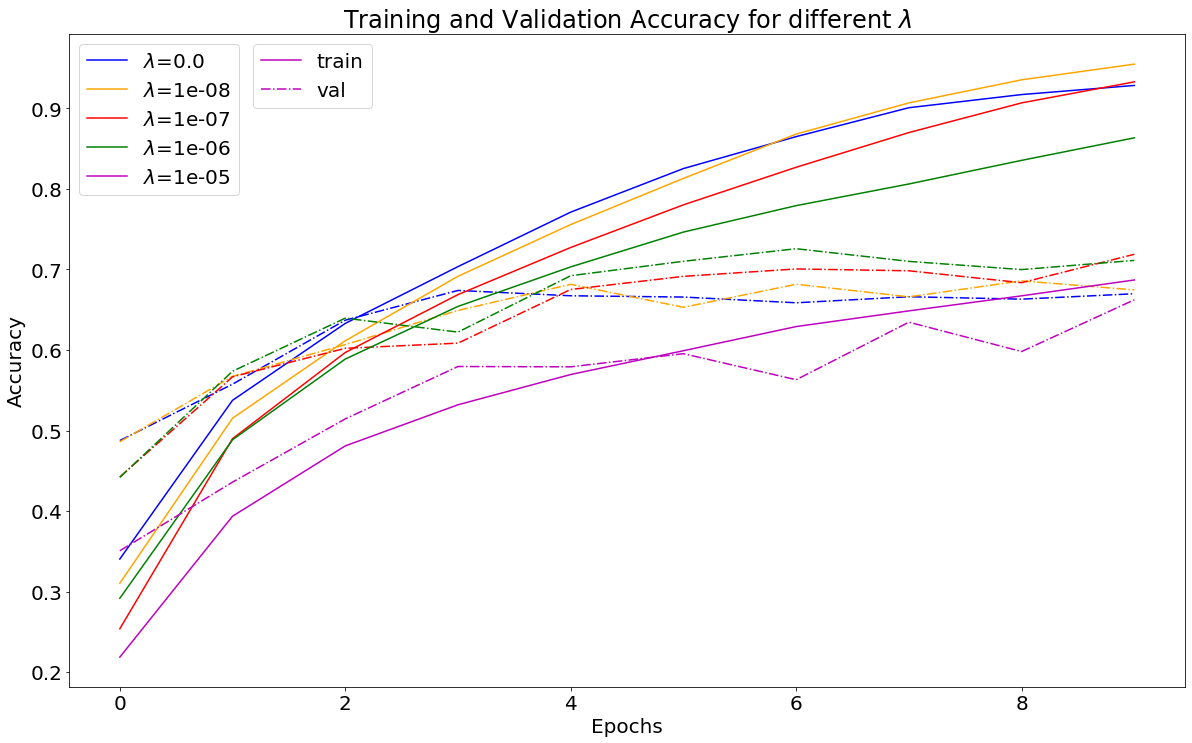

In [0]:
plt.figure(figsize=(20,12))
plt.rcParams.update({'font.size': 20})

colors = ['blue', 'orange', 'r', 'green', 'm', 'cyan', 'yellow', 'k']
res_dict = res3
for i, method in enumerate(['lbda_0.0', 'lbda_1e-08', 'lbda_1e-07', 'lbda_1e-06', 'lbda_1e-05']):
    line1, = plt.plot(res_dict[method]['acc'], c = colors[i], label = "$\lambda$="+method[5:])
    line2, = plt.plot(res_dict[method]['val_acc'], '-.', c = colors[i])

legend1 = plt.legend([line1, line2], ["train", "val"], loc='upper right', bbox_to_anchor=(0.28, 1))
plt.gca().add_artist(legend1)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for different $\lambda$')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # This is added back by InteractiveShellApp.init_path()


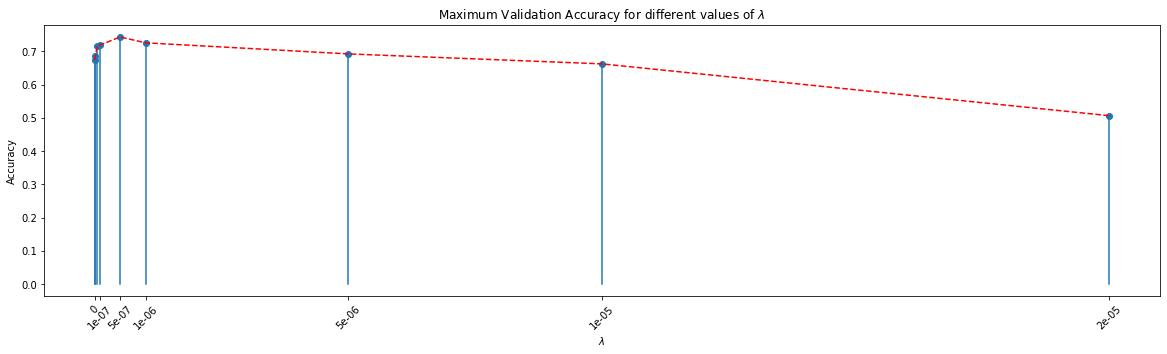

In [0]:
plt.figure(figsize=(20,5))
plt.rcParams.update({'font.size': 10})

lbdas = []
acc_values = []
for method in ['lbda_0.0','lbda_1e-08','lbda_5e-08','lbda_1e-07','lbda_5e-07',
               'lbda_1e-06','lbda_5e-06','lbda_1e-05','lbda_2e-05']:
    lbdas.append(float(method[5:]))
    acc_values.append(max(res_dict[method]['val_acc']))

plt.stem(lbdas, acc_values,basefmt=" ")
xticks_vals = [0, 1e-07, 5e-07, 1e-06, 5e-06, 1e-05, 2e-05]
plt.xticks(xticks_vals,[str(elt) for elt in xticks_vals], rotation = 45)
plt.plot(lbdas, acc_values, '--', c='r')
#plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Accuracy')
plt.title('Maximum Validation Accuracy for different values of $\lambda$')
plt.show()